# Textile Defect Detection

Credit: https://www.kaggle.com/code/muhmddanish/textile-defect-detection-binary-classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/dataset/test64.csv.zip


Archive:  /content/drive/MyDrive/dataset/test64.csv.zip
  inflating: test64.csv              


In [3]:
!unzip /content/drive/MyDrive/dataset/test64.h5.zip

Archive:  /content/drive/MyDrive/dataset/test64.h5.zip
  inflating: test64.h5               


In [4]:
!unzip /content/drive/MyDrive/dataset/train64.csv.zip


Archive:  /content/drive/MyDrive/dataset/train64.csv.zip
  inflating: train64.csv             


In [5]:
!unzip /content/drive/MyDrive/dataset/train64.h5.zip

Archive:  /content/drive/MyDrive/dataset/train64.h5.zip
  inflating: train64.h5              


In [6]:
!unzip /content/drive/MyDrive/dataset/matchingtDATASET_train_64.h5.zip

Archive:  /content/drive/MyDrive/dataset/matchingtDATASET_train_64.h5.zip
  inflating: matchingtDATASET_train_64.h5  


In [7]:
!unzip /content/drive/MyDrive/dataset/matchingtDATASET_test_64.h5.zip

Archive:  /content/drive/MyDrive/dataset/matchingtDATASET_test_64.h5.zip
  inflating: matchingtDATASET_test_64.h5  


## Import Libraries

In [8]:
# import the libraries
import os
import glob
import pickle
import tensorflow as tf # used for creating tensors out of the dataset and training the model
import numpy as np
import h5py # to manipulate the dataset as it's in '.h5' format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from tqdm import tqdm

## Load Dataset in CSV File Format

In [9]:
# Load the 'train64.csv' file
# train_df64 = pd.read_csv("./dataset/train64.csv")
train_df64 = pd.read_csv("/content/test64.csv")

# Convert the value of indication_type other than "good" to "damaged"
train_df64["indication_type"] = train_df64.indication_type.apply(lambda row: "damaged" if row != "good" else "good")

# Convert the value of indication_value other than "0" to "1",
# where "0" represents "good" and "1" represents "damaged"
train_df64["indication_value"] = train_df64.indication_value.apply(lambda row: 1 if row != 0 else 0)
train_df64.head()

,index,angle,indication_type,indication_value,split
0,0,100,good,0,test
1,1,40,good,0,test
2,2,40,good,0,test
3,3,120,good,0,test
4,4,20,good,0,test


In [10]:
# Check the proportion of instances in two classes
train_df64.indication_type.value_counts(normalize = True).round(2)

,proportion
indication_type,
damaged,0.83
good,0.17


(array([0, 1]), [Text(0, 0, 'damaged'), Text(1, 0, 'good')])

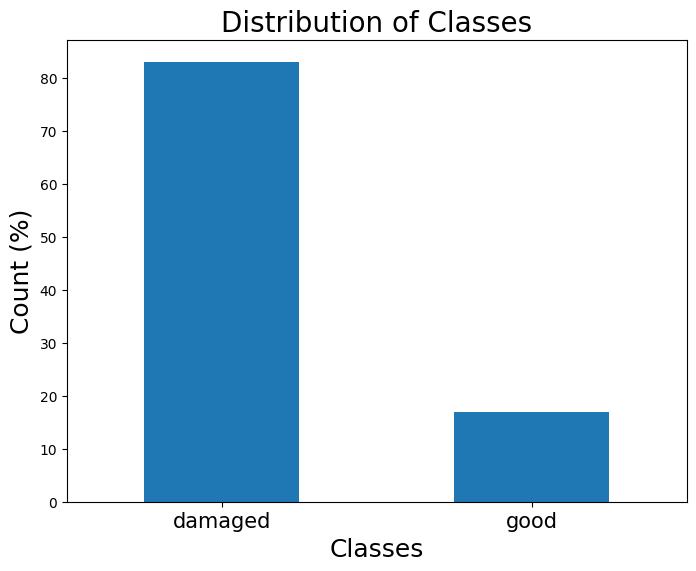

In [11]:
# Plot the proportion of instances in two classes
(train_df64.indication_type.value_counts(normalize = True).round(2) * 100).to_frame().plot.bar(legend = False, figsize = (8, 6))
plt.xlabel('Classes', fontsize = 18)
plt.ylabel("Count (%)", fontsize = 18)
plt.title("Distribution of Classes", fontsize = 20)
plt.xticks(rotation = 0, fontsize = 15)

After converting the training dataset of six classes into two classes (i.e., "good" and "damaged"), the training dataset suffers class imbalance.

In [12]:
# Read csv
df = pd.read_csv("/content/train64.csv")

# Counts
counts = df["indication_type"].value_counts()

# Percentage
percentages = df["indication_type"].value_counts(normalize=True) * 100

summary_table = pd.DataFrame({
    "Count": counts,
    "Percentage (%)": percentages.round(2)
})

summary_table = summary_table.sort_index()

print(summary_table)


                     Count  Percentage (%)
indication_type                           
color                 8000           16.67
cut                   8000           16.67
good                  8000           16.67
hole                  8000           16.67
metal_contamination   8000           16.67
thread                8000           16.67


## Data Preprocessing

In [13]:
# Create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
    def __init__(self, hdf_path, dataset_name = "train"):
        self.path = hdf_path

        self.classes = []
        with h5py.File(self.path, 'r') as hf:
            for class_ in hf:
                self.classes.append(class_)

        self.name = dataset_name


    # Create a generator to load the (img, class, angle)
    def generate_img_arr(self):
        for class_ in self.classes:
            with h5py.File(self.path, 'r') as hf:
                for angle in hf[class_]:
                    for img in hf[class_][f"{angle}"]:
                        yield img, class_, angle


    # Utilize the generator to create new images and load it back to Storage
    def generate_train_dirs(self):
        # Create the dataset's directories
        path = f"./dataset/{self.name}"
        os.makedirs(f"{path}/good/")
        os.makedirs(f"{path}/damaged/")

        random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")

        gen = self.generate_img_arr()
        metadata = {}

        for i, data in enumerate(gen):
            img, label, angle = data
            if label == "good":
                for j in range(4):
                    img_path = f"{path}/{label}/{i}_aug{j}.jpeg"
                    img = random_flip(tf.expand_dims(np.squeeze(img), axis = 2) * 255., training = True)
                    plt.imsave(img_path, np.squeeze(img), cmap = "gray")
            else:
                img_path = f"{path}/damaged/{i}.jpeg"
                plt.imsave(img_path, np.squeeze(img) * 255., cmap = "gray")

            metadata[img_path] = angle

        return metadata


    def generate_test_dirs(self):
        # Create the dataset's directories
        path = f"./dataset/{self.name}"
        os.makedirs(f"{path}/good/")
        os.makedirs(f"{path}/damaged/")

        gen = self.generate_img_arr()
        metadata = {}

        for i, data in enumerate(gen):
            img, label, angle = data
            if label == "good":
                img_path = f"{path}/{label}/{i}.jpeg"
                plt.imsave(img_path, np.squeeze(img) * 255., cmap = "gray")
            else:
                img_path = f"{path}/damaged/{i}.jpeg"
                plt.imsave(img_path, np.squeeze(img) * 255., cmap = "gray")

            metadata[img_path] = angle

        return metadata


    def to_storage(self):
        if self.name == "train":
            self.generate_train_dirs()

        elif self.name == "test":
            self.generate_test_dirs()

In [14]:
# Generate train data
# train_gen = H5ToStorage("./dataset/matchingtDATASET_train_64.h5", "train")
train_gen = H5ToStorage("matchingtDATASET_train_64.h5", "train")
train_dict = train_gen.to_storage()

In [15]:
# Generate test data
# test_gen = H5ToStorage("./dataset/matchingtDATASET_test_64.h5", "test")
test_gen = H5ToStorage("/content/matchingtDATASET_test_64.h5", "test")
test_dict = test_gen.to_storage()

## Load Image Datasets

In [16]:
# Paths of training and testing datasets
train_dir = "./dataset/train"
test_dir = "./dataset/test"

# Define some parameters for the loader
img_size = (64, 64)
batch_size = 32

In [17]:
# Create training dataset pipeline
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = train_dir,
    color_mode = 'grayscale',
    batch_size = batch_size,
    image_size = img_size,
    seed = 42,
    validation_split = 0.2,
    subset = 'training')

Found 108000 files belonging to 2 classes.
Using 86400 files for training.


In [18]:
# Create validation dataset pipeline
val_data = tf.keras.utils.image_dataset_from_directory(
    directory = train_dir,
    color_mode = 'grayscale',
    batch_size = batch_size,
    image_size = img_size,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation')

Found 108000 files belonging to 2 classes.
Using 21600 files for validation.


In [19]:
# Create testing dataset pipeline
test_data = tf.keras.utils.image_dataset_from_directory(
    directory = test_dir,
    color_mode = 'grayscale',
    batch_size = batch_size,
    image_size = img_size,
    shuffle = False)

Found 36000 files belonging to 2 classes.


In [20]:
# Print class names
class_names = train_data.class_names
class_names

['damaged', 'good']

In [21]:
# Configure the datasets for performance
# Use buffered prefetching to load images from disk without having I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size = AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size = AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size = AUTOTUNE)

## Data Exploration

In [22]:
# Check the proportion of instances in two classes
damaged_counts = 0
for _ in os.listdir(f"{train_dir}/damaged"):
    damaged_counts += 1

good_counts = 0
for _ in os.listdir(f"{train_dir}/good"):
    good_counts += 1

total = damaged_counts + good_counts

new_train_df64 = pd.Series({"damaged": damaged_counts/total,
                            "good": good_counts/total}).round(2)
new_train_df64

,0
damaged,0.56
good,0.44


(array([0, 1]), [Text(0, 0, 'damaged'), Text(1, 0, 'good')])

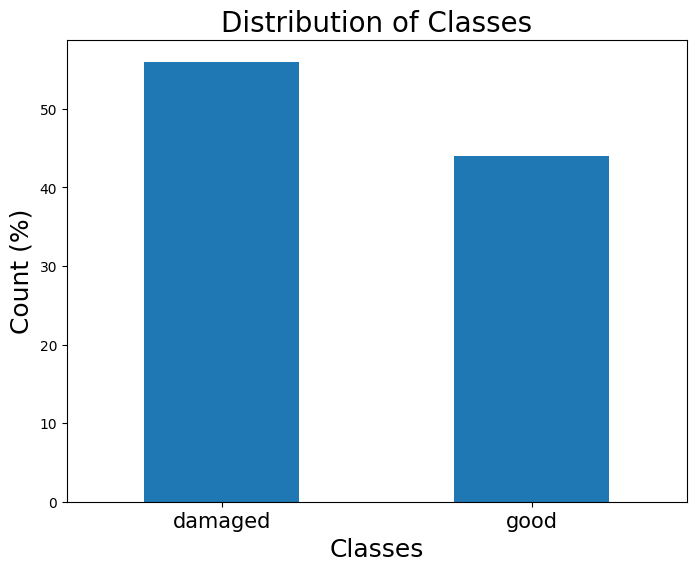

In [23]:
# Plot the proportion of instances in two classes
(new_train_df64 * 100).to_frame().plot.bar(legend = False, figsize = (8, 6))
plt.xlabel('Classes', fontsize = 18)
plt.ylabel("Count (%)", fontsize = 18)
plt.title("Distribution of Classes", fontsize = 20)
plt.xticks(rotation = 0, fontsize = 15)

Due to the data augmentation during preprocessing, the class imbalance has been reduced significantly.

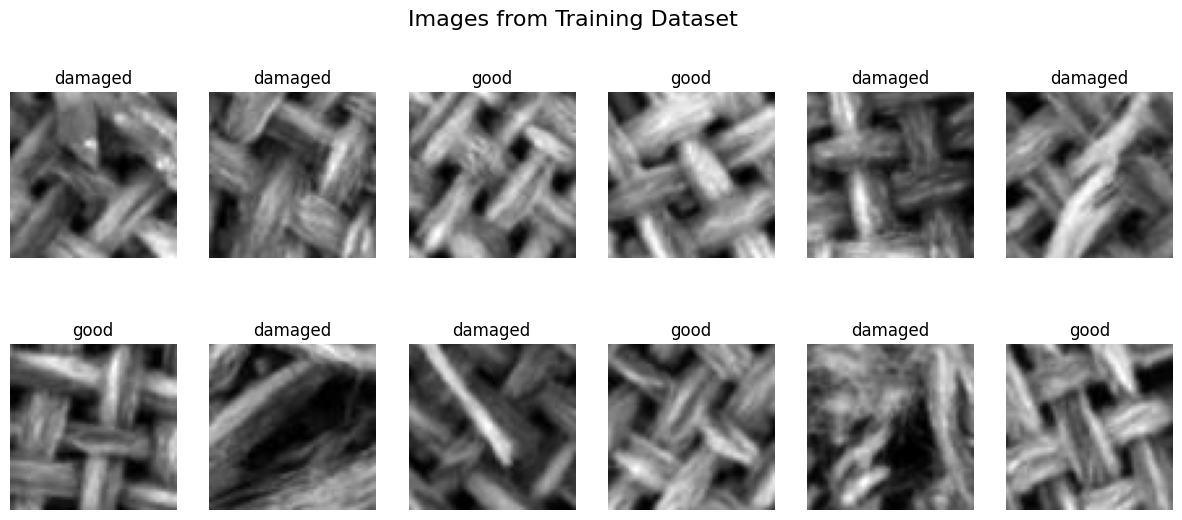

In [24]:
# Visualize the training dataset
plt.figure(figsize = (15, 6))
plt.suptitle("Images from Training Dataset", fontsize = 16)
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap = "gray")
        plt.title(f"{class_names[labels[i]]}")
        plt.axis("off")

## Model Building

### A. Baseline Model 1

In [25]:
baseline1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (64, 64, 1), name = 'input_layer'),
    tf.keras.layers.Conv2D(filters = 3, kernel_size = 1, activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = 2, activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = 4, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(filters = 512, kernel_size = 4, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid', name = 'output_layer')
])

In [26]:
# Get model summary
baseline1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 63, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 512)    │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,201,591 (4.58 MB)

 Trainable params: 1,201,591 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

### B. Baseline Model 2

In [27]:
baseline2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (64, 64, 1), name = 'input_layer'),
    tf.keras.layers.Rescaling(1./127.5, offset = -1),
    tf.keras.layers.Conv2D(filters = 3, kernel_size = 1, activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = 5, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(filters = 512, kernel_size = 5, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid', name = 'output_layer')
])

In [28]:
# Get model summary
baseline2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 58, 58, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 25, 25, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 512)      │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,867,943 (7.13 MB)

 Trainable params: 1,867,943 (7.13 MB)

 Non-trainable params: 0 (0.00 B)

### C.Transfer Learning: VGG-16

In [29]:
# Create the base model from the pre-trained model VGG-16
base_model = tf.keras.applications.vgg16.VGG16(include_top = False,
                                               weights = 'imagenet',
                                               input_shape = img_size + (3,))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
# Freeze the convolutional base to prevent the weights in a given layer
# from being updated during training
base_model.trainable = False

In [31]:
# Build the sequential model
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (64, 64, 1)),
    tf.keras.layers.Rescaling(1./127.5, offset = -1),
    tf.keras.layers.Conv2D(filters = 3, kernel_size = 1, padding = 'same'),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])

In [32]:
# Get model summary
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,487 (56.38 MB)

 Trainable params: 65,799 (257.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### D. Transfer Learning: Inception V3

In [33]:
# Create the base model from the pre-trained model VGG-16
img_shape = (128, 128) + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top = False,
                                                            weights = 'imagenet',
                                                            input_shape = img_shape)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:

# Freeze the convolutional base to prevent the weights in a given layer
# from being updated during training
base_model.trainable = False

In [35]:
# Build the sequential model
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (64, 64, 1)),
    tf.keras.layers.UpSampling2D(size = (2, 2), interpolation = 'bilinear'),
    tf.keras.layers.Rescaling(1./127.5, offset = -1),
    tf.keras.layers.Conv2D(filters = 3, kernel_size = 1, padding = 'same'),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])

In [36]:
# Get model summary
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 128, 128, 3)    │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,191 (84.17 MB)

 Trainable params: 262,407 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### E. Transfer Learning: DenseNet

In [37]:
# Create the base model from the pre-trained model VGG-16
base_model = tf.keras.applications.densenet.DenseNet121(include_top = False,
                                                        weights = 'imagenet',
                                                        input_shape = img_size + (3,))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [38]:
# Freeze the convolutional base to prevent the weights in a given layer
# from being updated during training
base_model.trainable = False

In [39]:
# Build the sequential model
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (64, 64, 1)),
    tf.keras.layers.Rescaling(1./127.5, offset = -1),
    tf.keras.layers.Conv2D(filters = 3, kernel_size = 1, padding = 'same'),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])

In [40]:
# Get model summary
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 64, 64, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,839 (27.35 MB)

 Trainable params: 131,335 (513.03 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

## Model Training

In [41]:
# Define callbacks
# Setup ReduceLROnPlateau callback to reduce learning rate
# if model's val_loss doesn't improve for 1 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                 factor = 0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience = 1,
                                                 verbose = 1, # print out when learning rate goes down
                                                 min_lr = 1e-7)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 3, # if val_accuracy decreases for 3 epochs in a row, stop training
                                                  restore_best_weights = True,
                                                  verbose = 1)

In [42]:
# Function to plot learning curves
def plot_learning_curves(history, restored_weight_epoch = None, annotate_loc = None):
    train_acc, train_loss = history.history["accuracy"], history.history["loss"]
    val_acc, val_loss = history.history["val_accuracy"], history.history["val_loss"]
    epochs = range(1, len(train_acc) + 1)

    # Plot accuracy curves
    plt.figure(figsize = (5, 4))
    plt.plot(epochs, train_acc, label = 'Training accuracy')
    plt.plot(epochs, val_acc, label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    if restored_weight_epoch:
        plt.axvline(restored_weight_epoch - 1, color = "red", linestyle = "--", label = "Restored Accuracy")
    if annotate_loc:
        plt.annotate("Restored Weights", xy = (restored_weight_epoch - 1, 0.94), xytext = (0.5, 0.93),
                     arrowprops = dict(facecolor = 'black', shrink = 0.05),)

    # Plot loss curves
    plt.figure(figsize = (5, 4))
    plt.plot(epochs, train_loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.legend()
    if restored_weight_epoch:
        plt.axvline(restored_weight_epoch - 1, color = "red", linestyle = "--")
    if annotate_loc:
        plt.annotate("Restored Weights", xy = (restored_weight_epoch - 1, 0.05), xytext = annoatate_loc,
                     arrowprops = dict(facecolor = 'black', shrink = 0.05),)

    plt.show()

### A. Baseline Model 1

In [43]:
# Compile the model
baseline1.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                 metrics = ['accuracy'])

In [75]:
# Train the model
num_epochs = 20
steps_per_epoch = len(train_data)

baseline1_history = baseline1.fit(train_data,
                                 epochs = num_epochs,
                                 steps_per_epoch = steps_per_epoch,
                                 validation_data = val_data,
                                 validation_steps = int(0.5 * len(val_data)),
                                 callbacks = [reduce_lr, early_stopping])

# Save the model to a HDF5 file (with '.h5' extension)
baseline1.save('baseline1.h5')

Epoch 1/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9050 - loss: 0.2711 - val_accuracy: 0.8903 - val_loss: 0.3035 - learning_rate: 0.0010
Epoch 2/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9118 - loss: 0.2562 - val_accuracy: 0.9025 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 3/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9134 - loss: 0.2594 - val_accuracy: 0.9073 - val_loss: 0.2664 - learning_rate: 0.0010
Epoch 4/20
2695/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9194 - loss: 0.2397
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9194 - loss: 0.2397 - val_accuracy: 0.9065 - val_loss: 0.2671 - learning_rate: 0.0010
Epoch 5/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9357 - loss: 0.2054 - val_accuracy: 0.9375 - val_loss: 0.1985 - learning_rate: 2.0000e-04
Epoch 6/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 

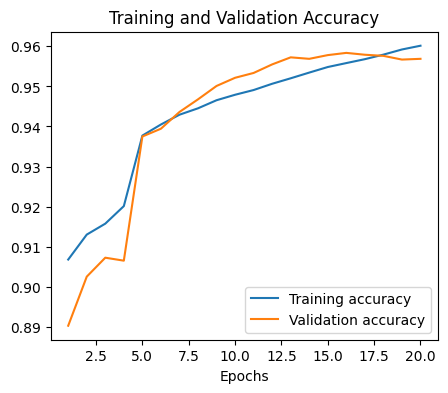

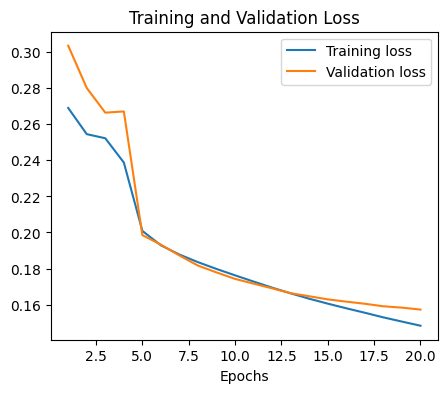

In [76]:
# Plot the learning curves
plot_learning_curves(baseline1_history)

### B. Baseline Model 2

In [77]:
# Compile the model
baseline2.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                 metrics = ['accuracy'])

In [78]:
# Train the model
num_epochs = 20
steps_per_epoch = len(train_data)

baseline2_history = baseline2.fit(train_data,
                                 epochs = num_epochs,
                                 steps_per_epoch = steps_per_epoch,
                                 validation_data = val_data,
                                 validation_steps = int(0.5 * len(val_data)),
                                 callbacks = [reduce_lr, early_stopping])

# Save the model to a HDF5 file (with '.h5' extension)
baseline2.save('baseline2.h5')

Epoch 1/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7005 - loss: 0.6494 - val_accuracy: 0.7839 - val_loss: 0.4761 - learning_rate: 0.0010
Epoch 2/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8141 - loss: 0.4354 - val_accuracy: 0.8692 - val_loss: 0.3465 - learning_rate: 0.0010
Epoch 3/20
2695/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8685 - loss: 0.3522
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8685 - loss: 0.3522 - val_accuracy: 0.8692 - val_loss: 0.3467 - learning_rate: 0.0010
Epoch 4/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8881 - loss: 0.3062 - val_accuracy: 0.8968 - val_loss: 0.2807 - learning_rate: 2.0000e-04
Epoch 5/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8899 - loss: 0.2925 - val_accuracy: 0.8989 - val_loss: 0.2716 - learning_rate: 2.0000e-04
Epoch 6/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accura

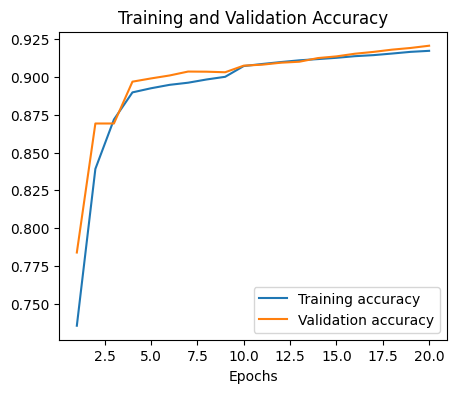

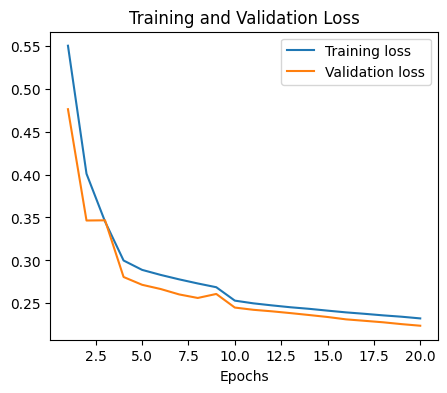

In [79]:
# Plot the learning curves
plot_learning_curves(baseline2_history)

### C. Transfer Learning: VGG-16

In [80]:
# Compile the model
model1.compile(optimizer = tf.keras.optimizers.Adam(),
               loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
               metrics = ['accuracy'])

In [81]:
# Train the model
num_epochs = 20
steps_per_epoch = len(train_data)

model1_history = model1.fit(train_data,
                            epochs = num_epochs,
                            steps_per_epoch = steps_per_epoch,
                            validation_data = val_data,
                            validation_steps = int(0.5 * len(val_data)),
                            callbacks = [reduce_lr, early_stopping])

# Save the model to a HDF5 file (with '.h5' extension)
model1.save('model1.h5')

Epoch 1/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9419 - loss: 0.1512 - val_accuracy: 0.9705 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 2/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9680 - loss: 0.0892 - val_accuracy: 0.9770 - val_loss: 0.0675 - learning_rate: 0.0010
Epoch 3/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9762 - loss: 0.0694 - val_accuracy: 0.9826 - val_loss: 0.0518 - learning_rate: 0.0010
Epoch 4/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9839 - loss: 0.0506 - val_accuracy: 0.9911 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 5/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9888 - loss: 0.0370 - val_accuracy: 0.9930 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 6/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9920 - loss: 0.0268 - val_accuracy: 0.9961 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 7/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9

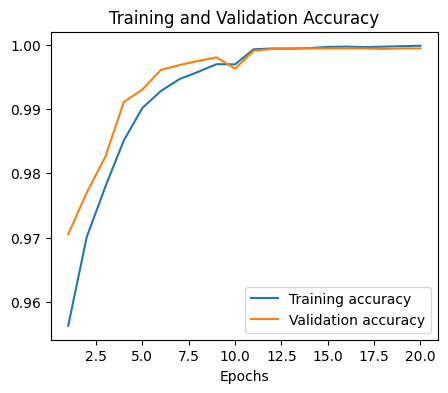

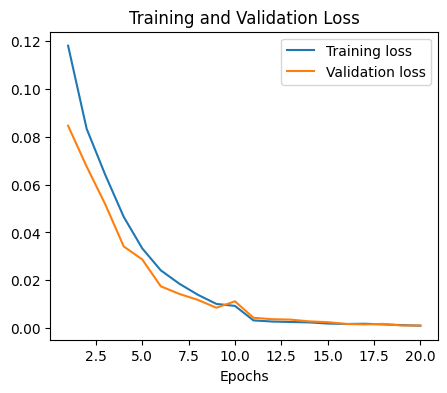

In [82]:
# Plot the learning curves
plot_learning_curves(model1_history)

### D. Transfer Learning: Inception V3

In [83]:
# Compile the model
model2.compile(optimizer = tf.keras.optimizers.Adam(),
               loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
               metrics = ['accuracy'])

In [84]:
# Train the model
num_epochs = 20
steps_per_epoch = len(train_data)

model2_history = model2.fit(train_data,
                            epochs = num_epochs,
                            steps_per_epoch = steps_per_epoch,
                            validation_data = val_data,
                            validation_steps = int(0.5 * len(val_data)),
                            callbacks = [reduce_lr, early_stopping])

# Save the model to a HDF5 file (with '.h5' extension)
model2.save('model2.h5')

Epoch 1/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - accuracy: 0.9046 - loss: 0.2502 - val_accuracy: 0.9446 - val_loss: 0.1444 - learning_rate: 0.0010
Epoch 2/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9428 - loss: 0.1431 - val_accuracy: 0.9571 - val_loss: 0.1129 - learning_rate: 0.0010
Epoch 3/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9555 - loss: 0.1150 - val_accuracy: 0.9594 - val_loss: 0.0991 - learning_rate: 0.0010
Epoch 4/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9652 - loss: 0.0916 - val_accuracy: 0.9736 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 5/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9698 - loss: 0.0778 - val_accuracy: 0.9827 - val_loss: 0.0498 - learning_rate: 0.0010
Epoch 6/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9758 - loss: 0.0633 - val_accuracy: 0.9849 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 7/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accura

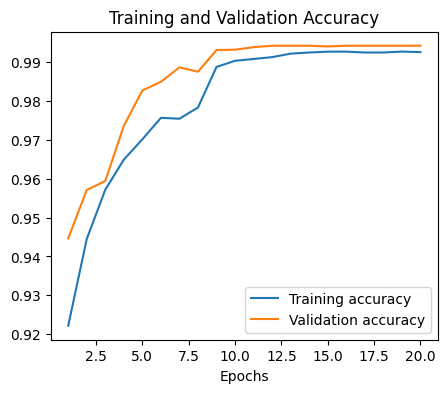

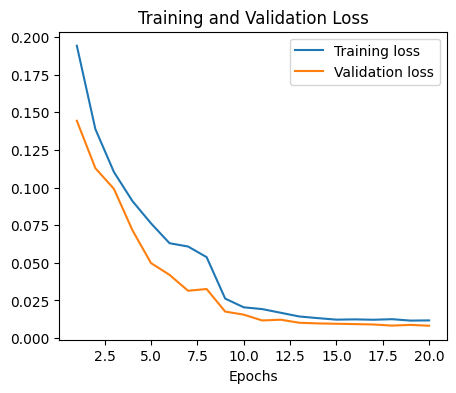

In [85]:
# Plot the learning curves
plot_learning_curves(model2_history)

### E. Transfer Learning: DenseNet

In [86]:
# Compile the model
model3.compile(optimizer = tf.keras.optimizers.Adam(),
               loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
               metrics = ['accuracy'])

In [87]:
# Train the model
num_epochs = 20
steps_per_epoch = len(train_data)

model3_history = model3.fit(train_data,
                            epochs = num_epochs,
                            steps_per_epoch = steps_per_epoch,
                            validation_data = val_data,
                            validation_steps = int(0.5 * len(val_data)),
                            callbacks = [reduce_lr, early_stopping])

# Save the model to a HDF5 file (with '.h5' extension)
model3.save('model3.h5')

Epoch 1/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 73s 17ms/step - accuracy: 0.9425 - loss: 0.1565 - val_accuracy: 0.9766 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 2/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.9756 - loss: 0.0674 - val_accuracy: 0.9885 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 3/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.9827 - loss: 0.0477 - val_accuracy: 0.9930 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 4/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.9890 - loss: 0.0327 - val_accuracy: 0.9926 - val_loss: 0.0251 - learning_rate: 0.0010
Epoch 5/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.9910 - loss: 0.0261 - val_accuracy: 0.9940 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 6/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.9924 - loss: 0.0210 - val_accuracy: 0.9963 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 7/20
2698/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accurac

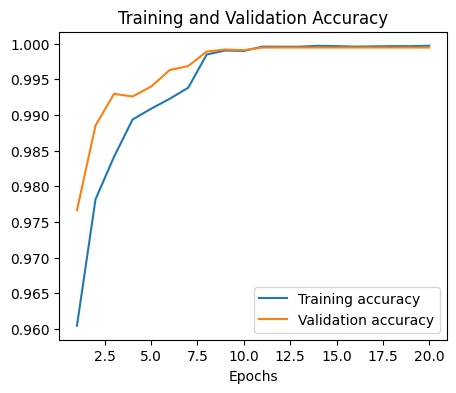

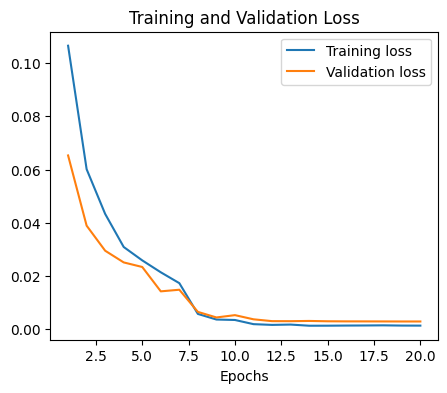

In [88]:
# Plot the learning curves
plot_learning_curves(model3_history)

## Model Testing and Evaluation

In [89]:
# Function to get the model's actual labels and predicted labels
def get_labels(dataset, model):
    y_labels = []
    for _, label in tqdm(dataset.unbatch()):
        y_labels.append(label)

    y_preds = model.predict(dataset, verbose = 1)
    return y_labels, y_preds

In [90]:
labels = ['damaged', 'good']

def evaluate_model(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)

    fig = plt.figure(figsize = (8, 8))
    ax = sns.heatmap(cm,
                     annot = True,
                     annot_kws = {'size': 12, 'weight': 'bold'},
                     cmap = 'RdPu',
                     linewidths = 0.1,
                     linecolor = 'grey',
                     square = True)

    ax.set_title('CONFUSION MATRIX\n\n', fontsize = 16, weight = 'bold')
    ax.set_xlabel('\nPREDICTED\n', fontsize = 14, weight = 'bold')
    ax.set_ylabel('ACTUAL     ', fontsize = 14, weight = 'bold')

    ax.xaxis.set_ticklabels(labels, rotation = 90, fontsize = '12')
    ax.yaxis.set_ticklabels(labels, fontsize = '12')

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize = 12)

    # Display the visualization of the Confusion Matrix.
    plt.show()

    classification_report = metrics.classification_report(y_test, y_pred, target_names = labels)
    print("\n\n")
    print("\t\t\t  **************************")
    print("\t\t\t  *  Classifiction Report  *")
    print("\t\t\t  **************************")
    print("\n")
    print(classification_report)

### A. Baseline Model 1

In [91]:
# Load the model
# Miss, I don't know why it can't be loaded without training it.
# baseline1 = tf.keras.models.load_model('./models/baseline1.h5')
baseline1 = tf.keras.models.load_model('/content/baseline1.h5')

In [92]:
# Model's loss and accuracy
baseline1.evaluate(test_data)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8508 - loss: 0.4481


[0.39772361516952515, 0.8684444427490234]

In [93]:
# Get the labels for model
y_test, y_pred = get_labels(test_data, baseline1)
y_pred = np.round(y_pred)

36000it [00:06, 5836.60it/s]


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


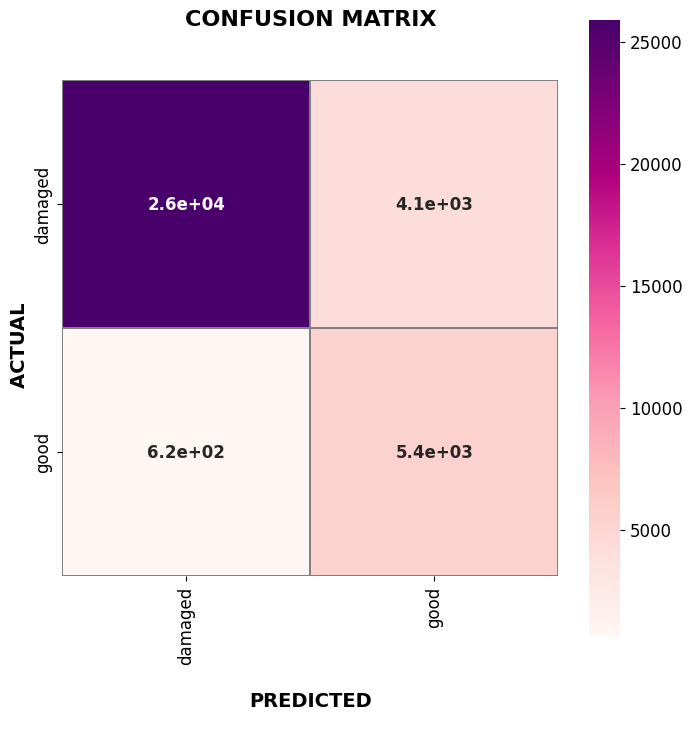




			  **************************
			  *  Classifiction Report  *
			  **************************


              precision    recall  f1-score   support

     damaged       0.98      0.86      0.92     30000
        good       0.57      0.90      0.69      6000

    accuracy                           0.87     36000
   macro avg       0.77      0.88      0.81     36000
weighted avg       0.91      0.87      0.88     36000



In [94]:
# Get the classification report
evaluate_model(y_test, y_pred)

### B. Baseline Model 2

In [95]:
# Load the model
# baseline2 = tf.keras.models.load_model('./models/baseline2.h5')
baseline2 = tf.keras.models.load_model('/content/baseline2.h5')

In [96]:
# Model's loss and accuracy
baseline2.evaluate(test_data)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8428 - loss: 0.3463


[0.3135533630847931, 0.8651111125946045]

In [97]:
# Get the labels for model
y_test, y_pred = get_labels(test_data, baseline2)
y_pred = np.round(y_pred)

36000it [00:06, 5846.34it/s]


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


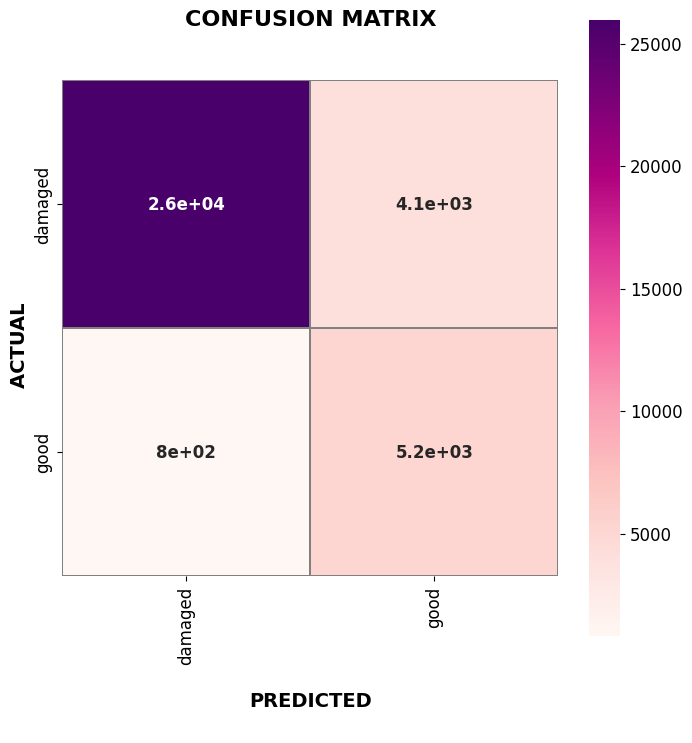




			  **************************
			  *  Classifiction Report  *
			  **************************


              precision    recall  f1-score   support

     damaged       0.97      0.86      0.91     30000
        good       0.56      0.87      0.68      6000

    accuracy                           0.87     36000
   macro avg       0.77      0.87      0.80     36000
weighted avg       0.90      0.87      0.88     36000



In [98]:
evaluate_model(y_test, y_pred)

### C. Transfer Learning: VGG-16

In [99]:
# Load the model
# model1 = tf.keras.models.load_model('./models/model1.h5')
model1 = tf.keras.models.load_model('/content/model1.h5')

In [100]:
# Model's loss and accuracy
model1.evaluate(test_data)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9287 - loss: 0.4838


[0.4759325683116913, 0.9328888654708862]

In [101]:
# Get the labels for model
y_test, y_pred = get_labels(test_data, model1)
y_pred = np.round(y_pred)

36000it [00:06, 5667.17it/s]


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


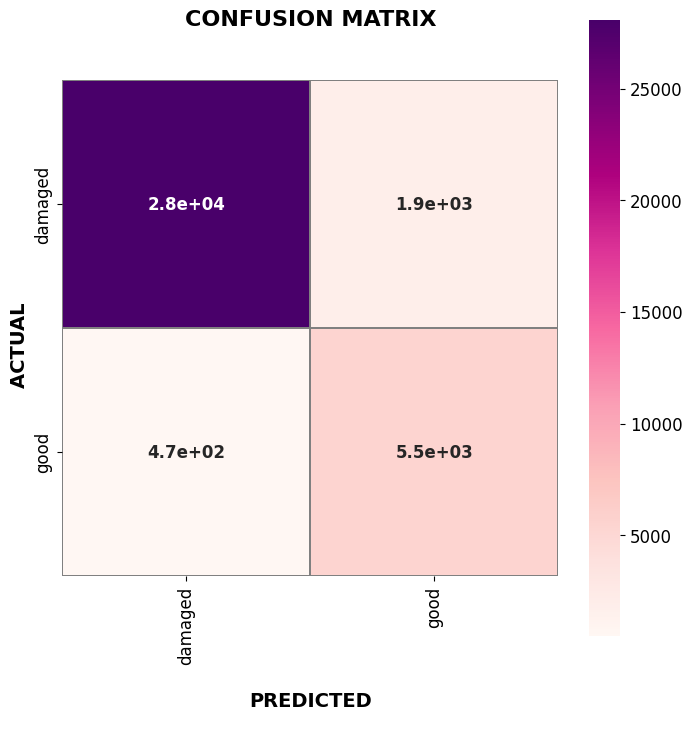




			  **************************
			  *  Classifiction Report  *
			  **************************


              precision    recall  f1-score   support

     damaged       0.98      0.94      0.96     30000
        good       0.74      0.92      0.82      6000

    accuracy                           0.93     36000
   macro avg       0.86      0.93      0.89     36000
weighted avg       0.94      0.93      0.94     36000



In [102]:
evaluate_model(y_test, y_pred)

### D. Transfer Learning: Inception V3

In [103]:
# Load the model
# model2 = tf.keras.models.load_model('./models/model2.h5')
model2 = tf.keras.models.load_model('/content/model2.h5')

In [104]:
# Model's loss and accuracy
model2.evaluate(test_data)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8975 - loss: 0.9465


[0.8688364624977112, 0.9039999842643738]

In [105]:
# Get the labels for model
y_test, y_pred = get_labels(test_data, model2)
y_pred = np.round(y_pred)

36000it [00:06, 5644.38it/s]


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step


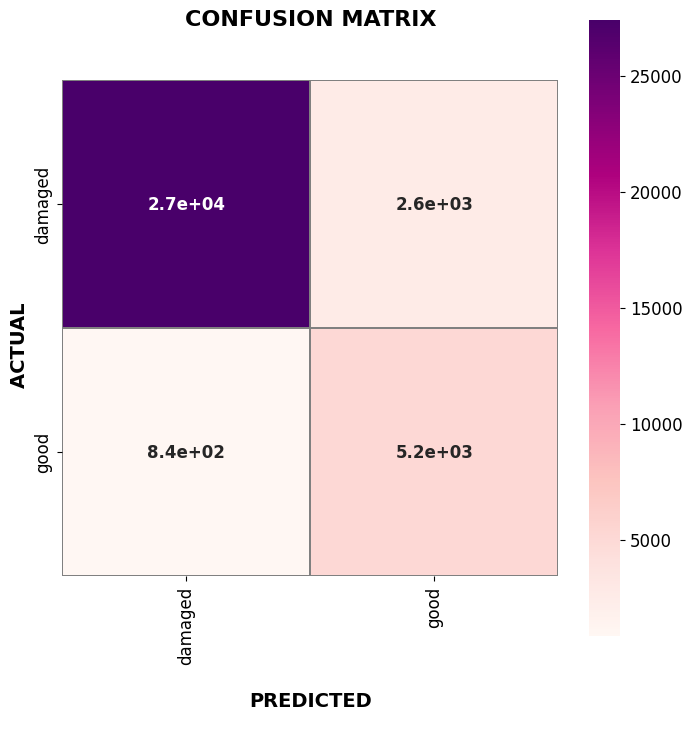




			  **************************
			  *  Classifiction Report  *
			  **************************


              precision    recall  f1-score   support

     damaged       0.97      0.91      0.94     30000
        good       0.66      0.86      0.75      6000

    accuracy                           0.90     36000
   macro avg       0.82      0.89      0.84     36000
weighted avg       0.92      0.90      0.91     36000



In [106]:
evaluate_model(y_test, y_pred)

### E. Transfer Learning: DenseNet-121

In [107]:
# Load the model
# model3 = tf.keras.models.load_model('./models/model3.h5')
model3 = tf.keras.models.load_model('/content/model3.h5')

In [108]:
# Model's loss and accuracy
model3.evaluate(test_data)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9429 - loss: 0.4787


[0.45230674743652344, 0.9442222118377686]

In [109]:
# Get the labels for model
y_test, y_pred = get_labels(test_data, model3)
y_pred = np.round(y_pred)

36000it [00:06, 5674.59it/s]


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step


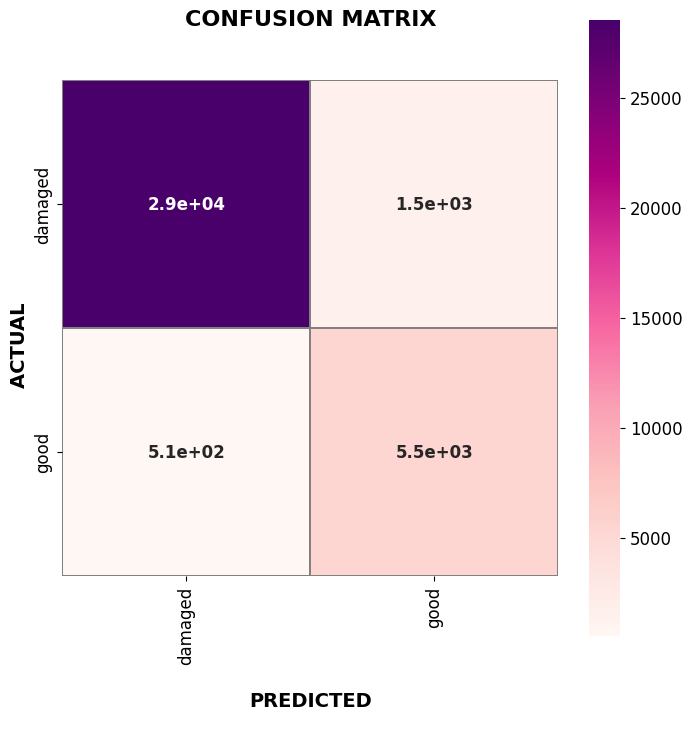




			  **************************
			  *  Classifiction Report  *
			  **************************


              precision    recall  f1-score   support

     damaged       0.98      0.95      0.97     30000
        good       0.79      0.91      0.85      6000

    accuracy                           0.94     36000
   macro avg       0.88      0.93      0.91     36000
weighted avg       0.95      0.94      0.95     36000



In [110]:
evaluate_model(y_test, y_pred)

## Ablation experiment

## B Fine-tune Last Block

## VGG last block frozen

In [45]:
# Create the base model from the pre-trained model VGG-16
base_model = tf.keras.applications.vgg16.VGG16(include_top = False,
                                               weights = 'imagenet',
                                               input_shape = img_size + (3,))

In [46]:
# Freeze everything first
base_model.trainable = False

# Only unfreeze the last block
for layer in base_model.layers:
    if layer.name.startswith("block5"):
        layer.trainable = True

print("VGG16 Number of trainable layers：", sum(1 for l in base_model.layers if l.trainable))

# Build the sequential model
vgg_lastblock_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 1)),
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    tf.keras.layers.Conv2D(filters=3, kernel_size=1, padding='same'),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

VGG16 Number of trainable layers： 4


In [47]:
# Compile the model
vgg_lastblock_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
                    metrics = ['accuracy'])

In [48]:
# Train the model
num_epochs = 20
steps_per_epoch = len(train_data)

history_vgg_lastblock = vgg_lastblock_model.fit(
    train_data,
    steps_per_epoch = steps_per_epoch,
    validation_data=val_data,
    epochs=num_epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model to a HDF5 file (with '.h5' extension)
vgg_lastblock_model.save('vgg_lastblock_model.h5')

Epoch 1/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.8909 - loss: 0.2483 - val_accuracy: 0.9795 - val_loss: 0.0672 - learning_rate: 1.0000e-05
Epoch 2/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9783 - loss: 0.0631 - val_accuracy: 0.9965 - val_loss: 0.0148 - learning_rate: 1.0000e-05
Epoch 3/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9956 - loss: 0.0139 - val_accuracy: 0.9993 - val_loss: 0.0039 - learning_rate: 1.0000e-05
Epoch 4/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9985 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 2.1732e-04 - learning_rate: 1.0000e-05
Epoch 5/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9979 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 6.1609e-05 - learning_rate: 1.0000e-05
Epoch 6/20
2697/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5328e-05
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
2700/2700 ━━━━━━━━━━━━━━━━━

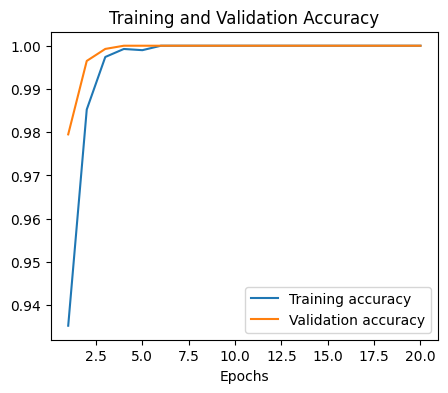

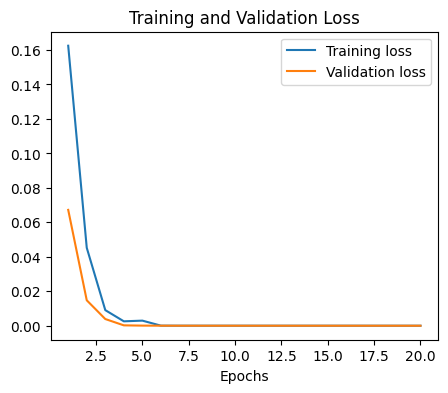

In [53]:
# Plot the learning curves
plot_learning_curves(history_vgg_lastblock)

## InceptionV3

In [49]:
# Create the base model from the pre-trained model VGG-16
img_shape = (128, 128) + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top = False,
                                                            weights = 'imagenet',
                                                            input_shape = img_shape)

In [50]:

# Freeze the convolutional base to prevent the weights in a given layer
# from being updated during training
base_model.trainable = False

In [51]:

# Only unfreeze the last few layers
set_trainable = False
for layer in base_model.layers:
    if layer.name.startswith("mixed7"):
        set_trainable = True
    if set_trainable:
        layer.trainable = True

print("InceptionV3 Number of trainable layers：", sum(1 for l in base_model.layers if l.trainable))

# Build the sequential model
inc_lastblock_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 1)),
    tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear'),
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    tf.keras.layers.Conv2D(filters=3, kernel_size=1, padding='same'),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

InceptionV3 Number of trainable layers： 83


In [52]:
# fine-tune
inc_lastblock_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_inc_lastblock = inc_lastblock_model.fit(
    train_data,
    steps_per_epoch = steps_per_epoch,
    validation_data=val_data,
    epochs=num_epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model to a HDF5 file (with '.h5' extension)
inc_lastblock_model.save('inc_lastblock_model.h5')

Epoch 1/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 87s 19ms/step - accuracy: 0.8951 - loss: 0.2392 - val_accuracy: 0.9987 - val_loss: 0.0057 - learning_rate: 1.0000e-05
Epoch 2/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.9964 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 3.7241e-04 - learning_rate: 1.0000e-05
Epoch 3/20
2697/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 8.8666e-04
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 1.0000 - loss: 8.8639e-04 - val_accuracy: 0.9971 - val_loss: 0.0080 - learning_rate: 1.0000e-05
Epoch 4/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 8.6285e-05 - learning_rate: 2.0000e-06
Epoch 5/20
2697/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.4780e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
2700/2700 ━━━━━━━━━━

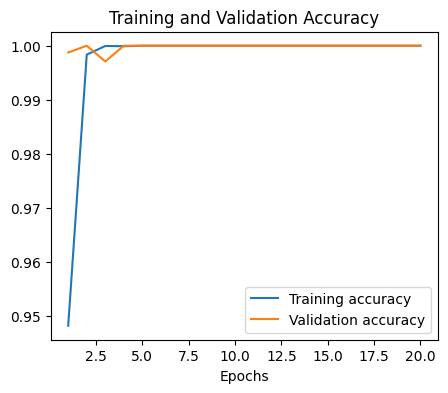

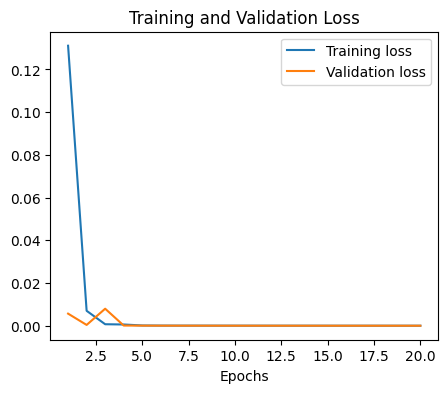

In [54]:
# Plot the learning curves
plot_learning_curves(history_inc_lastblock)

## DenseNet

In [55]:
# Create the base model from the pre-trained model VGG-16
base_model = tf.keras.applications.densenet.DenseNet121(include_top = False,
                                                        weights = 'imagenet',
                                                        input_shape = img_size + (3,))

In [56]:
# Freeze the convolutional base to prevent the weights in a given layer
# from being updated during training
base_model.trainable = False

In [57]:

# Only unfreeze the last dense block
for layer in base_model.layers:
    if "conv5_block" in layer.name:
        layer.trainable = True

print("DenseNet Number of trainable layers：", sum(1 for l in base_model.layers if l.trainable))

# Build the sequential model
dense_lastblock_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 1)),
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    tf.keras.layers.Conv2D(filters=3, kernel_size=1, padding='same'),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

DenseNet Number of trainable layers： 112


In [58]:
# fine-tune
dense_lastblock_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_dense_lastblock = dense_lastblock_model.fit(
    train_data,
    steps_per_epoch = steps_per_epoch,
    validation_data=val_data,
    epochs=num_epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model to a HDF5 file (with '.h5' extension)
dense_lastblock_model.save('dense_lastblock_model.h5')

Epoch 1/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 118s 21ms/step - accuracy: 0.8353 - loss: 0.3465 - val_accuracy: 0.9664 - val_loss: 0.0996 - learning_rate: 1.0000e-05
Epoch 2/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 0.9631 - loss: 0.1059 - val_accuracy: 0.9960 - val_loss: 0.0206 - learning_rate: 1.0000e-05
Epoch 3/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 0.9937 - loss: 0.0274 - val_accuracy: 0.9998 - val_loss: 0.0025 - learning_rate: 1.0000e-05
Epoch 4/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - accuracy: 0.9999 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 4.4286e-04 - learning_rate: 1.0000e-05
Epoch 5/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 1.0000 - loss: 8.7210e-04 - val_accuracy: 1.0000 - val_loss: 9.4660e-05 - learning_rate: 1.0000e-05
Epoch 6/20
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.8209e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
2700/2700 ━━━━━━━

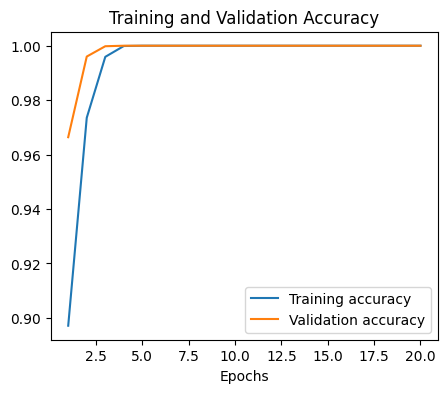

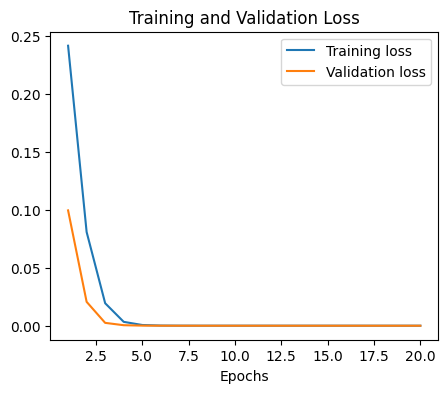

In [59]:
# Plot the learning curves
plot_learning_curves(history_dense_lastblock)

## Evaluation

### C. Transfer Learning: VGG-16

In [60]:
# Load the model
# model1 = tf.keras.models.load_model('./models/model1.h5')
vgg_lastblock_model = tf.keras.models.load_model('/content/vgg_lastblock_model.h5')

In [61]:
# Model's loss and accuracy
vgg_lastblock_model.evaluate(test_data)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9316 - loss: 0.6268


[0.5902623534202576, 0.9326666593551636]

In [65]:
# Get the labels for model
y_test, y_pred = get_labels(test_data, vgg_lastblock_model)
y_pred = np.round(y_pred)

36000it [00:06, 5278.20it/s]


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


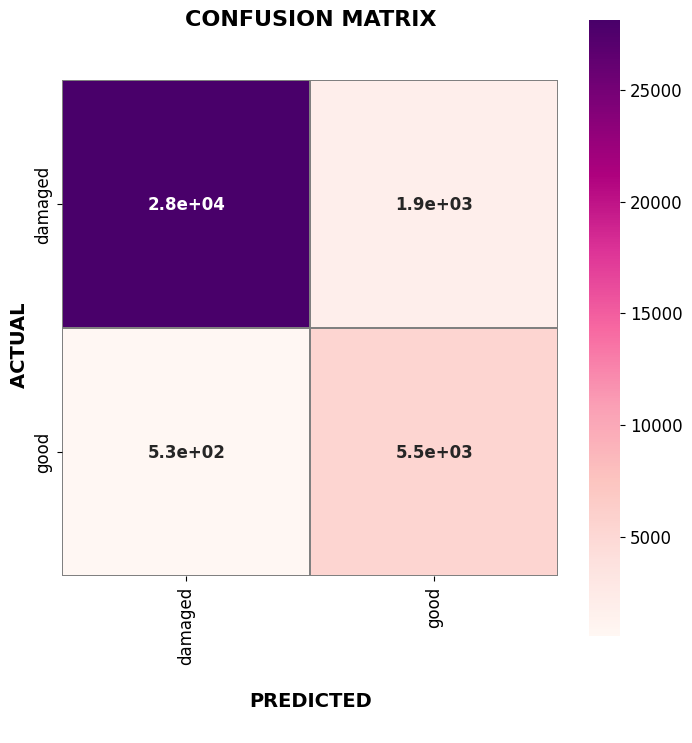




			  **************************
			  *  Classifiction Report  *
			  **************************


              precision    recall  f1-score   support

     damaged       0.98      0.94      0.96     30000
        good       0.74      0.91      0.82      6000

    accuracy                           0.93     36000
   macro avg       0.86      0.92      0.89     36000
weighted avg       0.94      0.93      0.94     36000



In [66]:
evaluate_model(y_test, y_pred)

### D. Transfer Learning: Inception V3

In [67]:
# Load the model
# model2 = tf.keras.models.load_model('./models/model2.h5')
inc_lastblock_model = tf.keras.models.load_model('/content/inc_lastblock_model.h5')


In [68]:
# Model's loss and accuracy
inc_lastblock_model.evaluate(test_data)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8882 - loss: 0.9010


[0.7807350754737854, 0.8971111178398132]

In [69]:
# Get the labels for model
y_test, y_pred = get_labels(test_data, inc_lastblock_model)
y_pred = np.round(y_pred)

36000it [00:06, 5660.18it/s]


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step


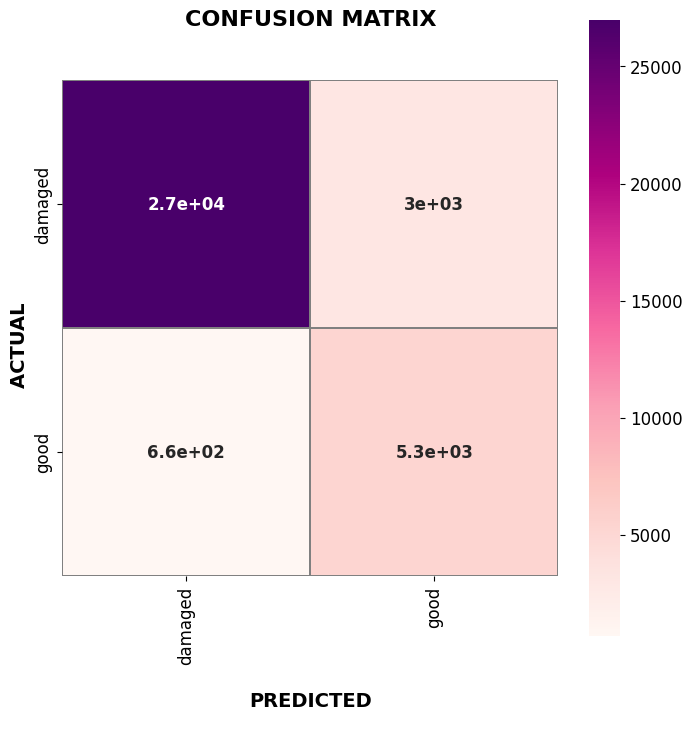




			  **************************
			  *  Classifiction Report  *
			  **************************


              precision    recall  f1-score   support

     damaged       0.98      0.90      0.94     30000
        good       0.64      0.89      0.74      6000

    accuracy                           0.90     36000
   macro avg       0.81      0.89      0.84     36000
weighted avg       0.92      0.90      0.90     36000



In [70]:
evaluate_model(y_test, y_pred)

### E. Transfer Learning: DenseNet-121

In [71]:
# Load the model
# model3 = tf.keras.models.load_model('./models/model3.h5')
dense_lastblock_model = tf.keras.models.load_model('/content/dense_lastblock_model.h5')

In [72]:
# Model's loss and accuracy
dense_lastblock_model.evaluate(test_data)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8772 - loss: 1.0336


[0.9419260025024414, 0.8813333511352539]

In [73]:
# Get the labels for model
y_test, y_pred = get_labels(test_data, dense_lastblock_model)
y_pred = np.round(y_pred)

36000it [00:06, 5700.79it/s]


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step


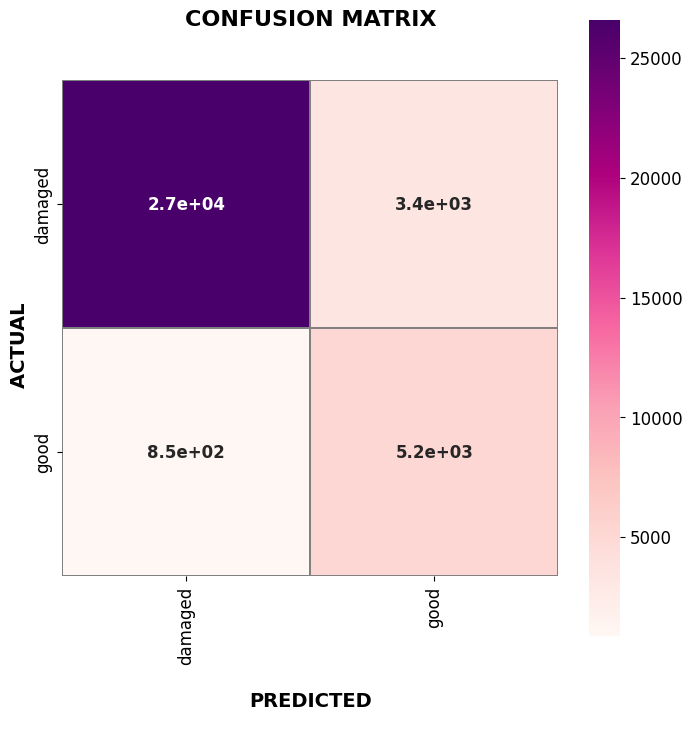




			  **************************
			  *  Classifiction Report  *
			  **************************


              precision    recall  f1-score   support

     damaged       0.97      0.89      0.93     30000
        good       0.60      0.86      0.71      6000

    accuracy                           0.88     36000
   macro avg       0.78      0.87      0.82     36000
weighted avg       0.91      0.88      0.89     36000



In [74]:
evaluate_model(y_test, y_pred)

## Function to remove the dataset

In [ ]:
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = './dataset'
remove_folder_contents(folder_path)